#Scenic Image Classification (CNN)

1. Initially we will import necessary packages


# Import Packages

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Data
Using a load_data function we are loading the images from dataset folder.

In [4]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """

    datasets = ['/content/drive/MyDrive/Datasets/seg_train/seg_train', '/content/drive/MyDrive/Datasets/seg_test/seg_test']
    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            # print(len(os.listdir(os.path.join(dataset, folder))))
            # Iterate through each image in our folder
            l=os.listdir(os.path.join(dataset, folder))[:1000]
            print(len(l))
            for file in tqdm(l):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))

    return output

In [5]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /content/drive/MyDrive/Datasets/seg_train/seg_train
1000


100%|██████████| 1000/1000 [00:47<00:00, 21.13it/s]


1000


100%|██████████| 1000/1000 [00:53<00:00, 18.77it/s]


1000


100%|██████████| 1000/1000 [00:49<00:00, 20.01it/s]


1000


100%|██████████| 1000/1000 [01:02<00:00, 15.94it/s]


1000


100%|██████████| 1000/1000 [01:13<00:00, 13.58it/s]


1000


100%|██████████| 1000/1000 [01:20<00:00, 12.36it/s]


Loading /content/drive/MyDrive/Datasets/seg_test/seg_test
510


100%|██████████| 510/510 [00:23<00:00, 21.75it/s] 


437


100%|██████████| 437/437 [00:16<00:00, 26.06it/s] 


501


100%|██████████| 501/501 [00:10<00:00, 45.64it/s] 


525


100%|██████████| 525/525 [00:12<00:00, 41.21it/s] 


553


100%|██████████| 553/553 [00:15<00:00, 34.79it/s] 


474


100%|██████████| 474/474 [00:15<00:00, 29.63it/s] 


In [6]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

# Explore the dataset

* Total number of training and testing examples in our dataset



In [7]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 6000
Number of testing examples: 3000
Each image is of size: (150, 150)


Displaying Number of training and testing images

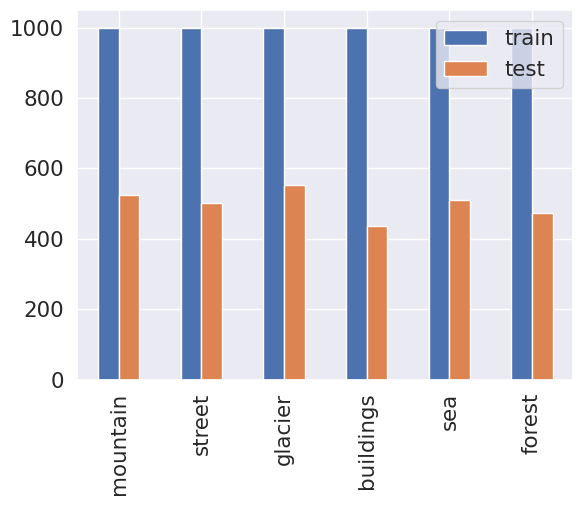

In [8]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts},
             index=class_names
            ).plot.bar()
plt.show()

Percentage of each category of datasets

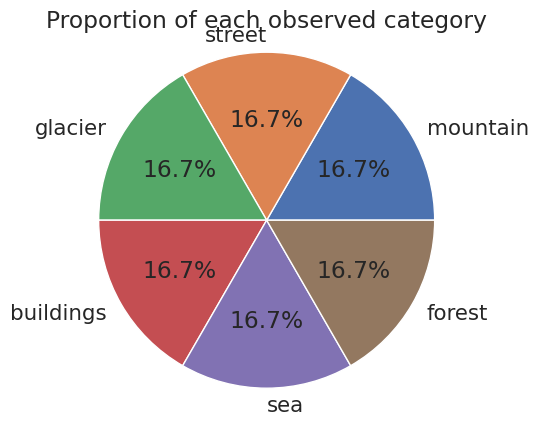

In [9]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) ,
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

## scale the data

In [10]:
train_images = train_images / 255.0
test_images = test_images / 255.0

## Visualize the data
We will display a random image from the training set.

In [11]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """

    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

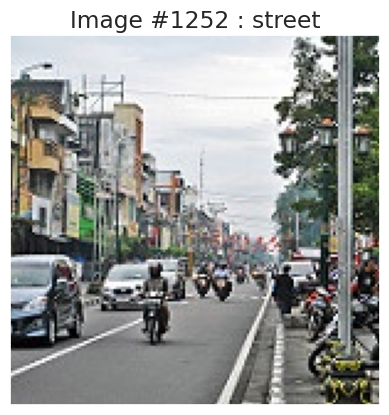

In [12]:
display_random_image(class_names, train_images, train_labels)

Now we are displaying the first 25 images from the training set directly using a loop to get a better view of images


In [13]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

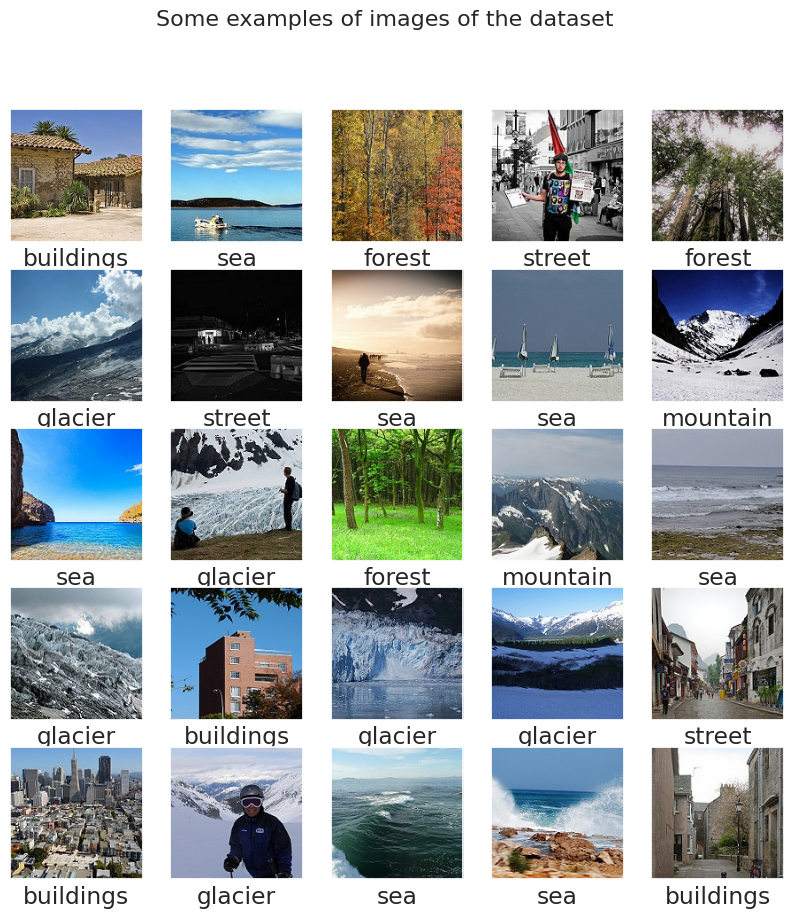

In [14]:
display_examples(class_names, train_images, train_labels)

# Defining a CNN Model

We are defining CNN model for classification task, where the input images are expected to have dimensions of 150x150 pixels with 3 color channels (RGB), and the model outputs the probability distribution over 6 classes.

Steps Include:
1. Build the model,
1. Compile the model,
1. Train / fit the data to the model,
1. Evaluate the model on the testing set,
1. Perform an error analysis of our model.

We are building our model composed of different layers such as:
* Conv2D, MaxPooling2D, Flatten, Relu, and Softmax:

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

After, building a model we are compileing it with some parameters such as:
* **Optimizer**: adam = RMSProp + Momentum.
What is Momentum and RMSProp ?
* Momentum = takes into account past gradient to have a better update.
* RMSProp = exponentially weighted average of the squares of past gradients.
* **Loss function**: we use sparse categorical crossentropy for classification, each images belongs to one class only

In [16]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Fitting the model to the data from the training set. The neural network will learn by on it's own to distinguish each category.

In [17]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
38/38 [==============================] - 11s 121ms/step - loss: 1.3764 - accuracy: 0.4913 - val_loss: 1.0419 - val_accuracy: 0.6008
Epoch 2/10
38/38 [==============================] - 3s 76ms/step - loss: 0.8857 - accuracy: 0.6727 - val_loss: 0.9210 - val_accuracy: 0.6683
Epoch 3/10
38/38 [==============================] - 3s 75ms/step - loss: 0.7206 - accuracy: 0.7365 - val_loss: 0.8272 - val_accuracy: 0.7017
Epoch 4/10
38/38 [==============================] - 3s 82ms/step - loss: 0.5415 - accuracy: 0.8004 - val_loss: 0.7432 - val_accuracy: 0.7258
Epoch 5/10
38/38 [==============================] - 3s 68ms/step - loss: 0.3872 - accuracy: 0.8694 - val_loss: 0.8373 - val_accuracy: 0.7108
Epoch 6/10
38/38 [==============================] - 2s 62ms/step - loss: 0.2667 - accuracy: 0.9181 - val_loss: 0.8013 - val_accuracy: 0.7392
Epoch 7/10
38/38 [==============================] - 2s 63ms/step - loss: 0.1940 - accuracy: 0.9440 - val_loss: 0.7381 - val_accuracy: 0.7633
Epoch 8/10


In [18]:
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

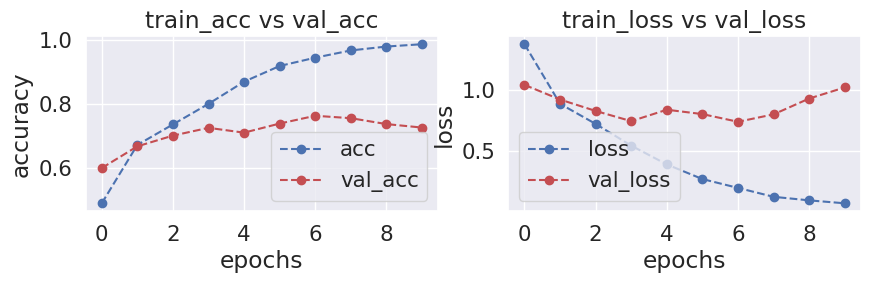

In [19]:
plot_accuracy_loss(history)

We should evaluate the model performance on test set

In [20]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 1s 10ms/step - loss: 1.0048 - accuracy: 0.7407


In [21]:
model.save('tedtyf.h5') #Saving the file

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


With our model we are getting 0.76 accuracy on the testing test.

We will check how our classifier is doing on random images.

94/94 [==============================] - 1s 9ms/step


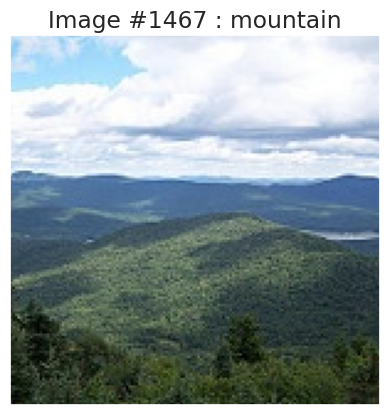

In [22]:
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis = 1)

display_random_image(class_names, test_images, pred_labels)

## Error analysis

We can understand the classifier has problem with certain kinds of images, and will see on which kind of images the classifier has trouble.

In [23]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)


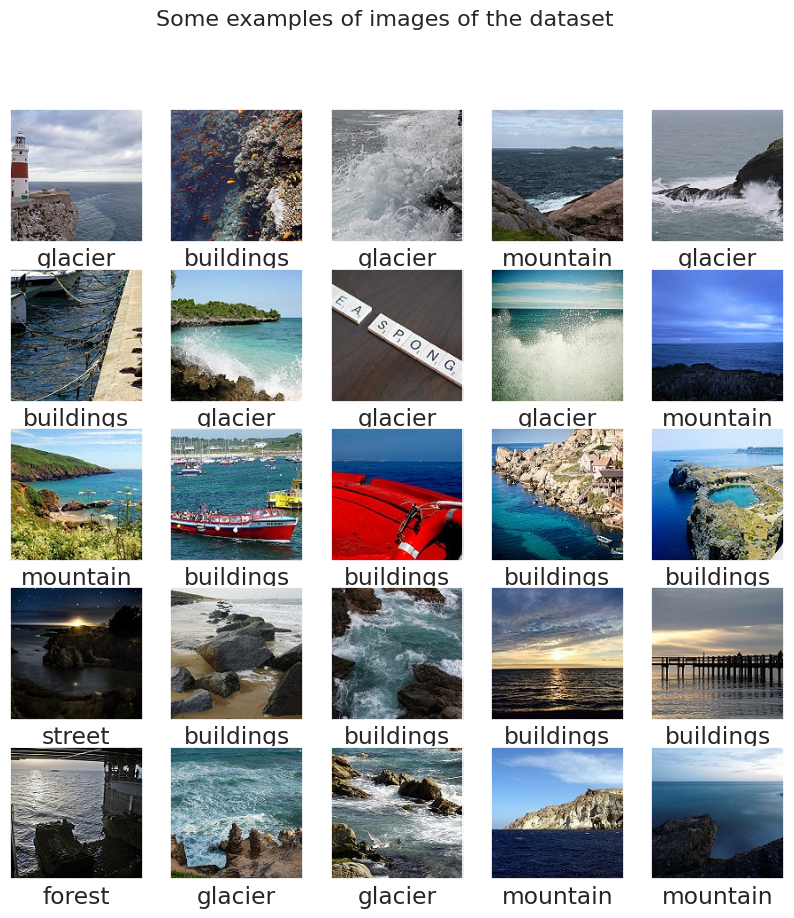

In [24]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

Computing the confusion matrix using the true and predicted labels

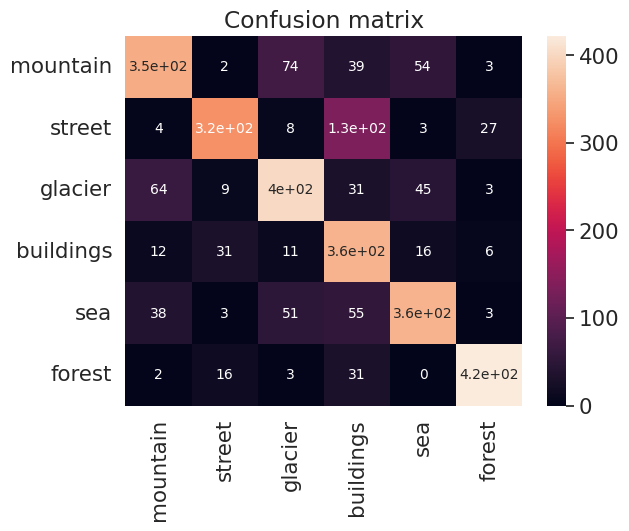

In [25]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True,
           annot_kws={"size": 10},
           xticklabels=class_names,
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

## Conclusion: The Model has trouble with two kinds of images.
The model has trouble with street and buildings, As buildings are part of streets it is facing problem with them. Along with these it also has problem with sea, glacier and mountains as well.

As our base model has a problem with those datasets, we are choosing another model (VGG) for better results.

We will implement the below steps to improve the results on our datasets.

* Feature extraction with VGG16 trained on ImageNet

* Ensemble models of Neural Networks with the features extracted from VGG

* Fine Tuning with VGG16 trained on ImageNet

# Feature extraction with VGG ImageNet

Extract features from VGG16.

In [26]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


Get the features directly from VGG16

In [27]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

94/94 [==============================] - 8s 88ms/step


## Visualize the features through PCA

In [28]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [29]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) # Représentation des individus dans les nouveaux axe
C1 = C[:,0]
C2 = C[:,1]

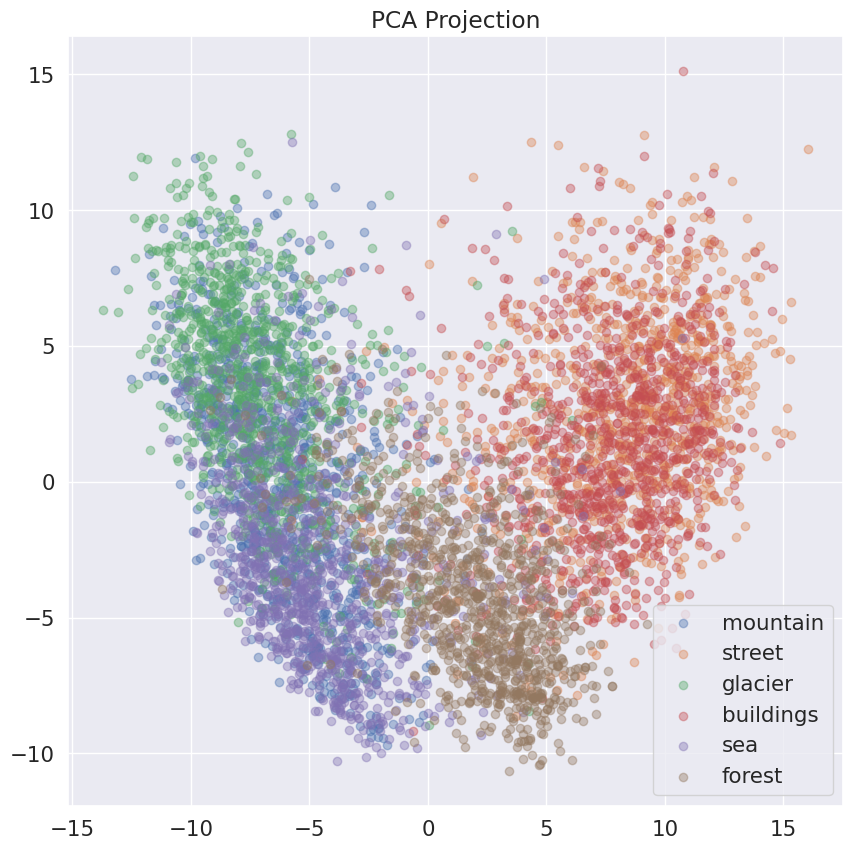

In [30]:
### Figures

plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

We can identifying clusters thanks to this PCA. The clusters correspond more or less to the labels.

We see that glacier and mountain points are very close to each other, as VGG sees them as very similar.

We see that there is no distinction between building and street.


## Training on top of VGG

We will train a simple one-layer Neural Network on the features extracted from VGG.

In [31]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
38/38 [==============================] - 2s 11ms/step - loss: 0.6744 - accuracy: 0.7569 - val_loss: 0.4686 - val_accuracy: 0.8217
Epoch 2/15
38/38 [==============================] - 0s 7ms/step - loss: 0.3458 - accuracy: 0.8712 - val_loss: 0.4001 - val_accuracy: 0.8567
Epoch 3/15
38/38 [==============================] - 0s 6ms/step - loss: 0.2613 - accuracy: 0.9071 - val_loss: 0.3834 - val_accuracy: 0.8575
Epoch 4/15
38/38 [==============================] - 0s 6ms/step - loss: 0.2050 - accuracy: 0.9344 - val_loss: 0.4072 - val_accuracy: 0.8558
Epoch 5/15
38/38 [==============================] - 0s 6ms/step - loss: 0.1730 - accuracy: 0.9431 - val_loss: 0.3939 - val_accuracy: 0.8617
Epoch 6/15
38/38 [==============================] - 0s 6ms/step - loss: 0.1474 - accuracy: 0.9556 - val_loss: 0.4067 - val_accuracy: 0.8658
Epoch 7/15
38/38 [==============================] - 0s 6ms/step - loss: 0.1217 - accuracy: 0.9654 - val_loss: 0.4124 - val_accuracy: 0.8625
Epoch 8/15
38/38 [=

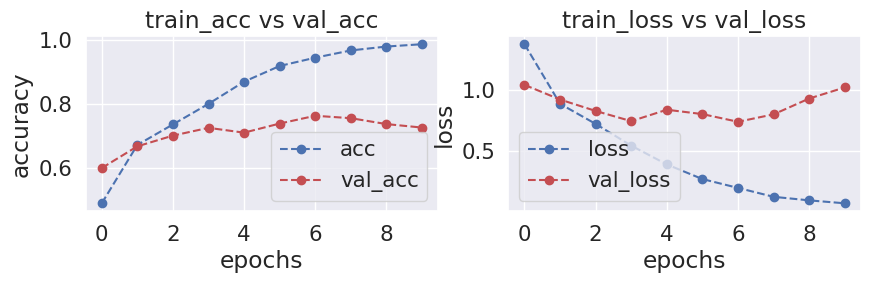

In [32]:
plot_accuracy_loss(history)

In [33]:
test_loss = model2.evaluate(test_features, test_labels)

94/94 [==============================] - 0s 3ms/step - loss: 0.4382 - accuracy: 0.8667


# Ensemble Neural Networks

In [34]:
np.random.seed(seed=1997)
# Number of estimators
n_estimators = 10
# Proporition of samples to use to train each training
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

We define n_estimators Neural Networks.

Each Neural Network will be trained on random subsets of the training dataset. Each subset contains max_samples samples.

In [35]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):

    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

    # Store model
    models.append(model)

In [36]:
model.save('ensemble.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
histories = []

for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.1))

Epoch 1/10
34/34 [==============================] - 1s 10ms/step - loss: 0.6746 - accuracy: 0.7558 - val_loss: 0.4583 - val_accuracy: 0.8500
Epoch 2/10
34/34 [==============================] - 0s 5ms/step - loss: 0.2774 - accuracy: 0.9051 - val_loss: 0.3640 - val_accuracy: 0.8938
Epoch 3/10
34/34 [==============================] - 0s 5ms/step - loss: 0.1833 - accuracy: 0.9463 - val_loss: 0.3740 - val_accuracy: 0.9000
Epoch 4/10
34/34 [==============================] - 0s 5ms/step - loss: 0.1409 - accuracy: 0.9627 - val_loss: 0.3283 - val_accuracy: 0.9104
Epoch 5/10
34/34 [==============================] - 0s 6ms/step - loss: 0.1033 - accuracy: 0.9741 - val_loss: 0.3070 - val_accuracy: 0.9208
Epoch 6/10
34/34 [==============================] - 0s 5ms/step - loss: 0.0773 - accuracy: 0.9847 - val_loss: 0.3159 - val_accuracy: 0.9187
Epoch 7/10
34/34 [==============================] - 0s 5ms/step - loss: 0.0615 - accuracy: 0.9884 - val_loss: 0.3216 - val_accuracy: 0.9187
Epoch 8/10
34/34 [=

In [38]:
model2.save('vgg.h5')

We aggregate each model individual predictions to form a final prediction.

In [39]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))

predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

94/94 [==============================] - 0s 2ms/step


In [40]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.874


# Fine Tuning VGG ImageNet

In [41]:
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [42]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

94/94 [==============================] - 5s 53ms/step


In [43]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
layer_input = Input(shape = (9, 9, 512)) # a new input tensor to be able to feed the desired layer
# https://stackoverflow.com/questions/52800025/keras-give-input-to-intermediate-layer-and-get-final-output

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(6,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [44]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [45]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 9, 9, 512)]       0         
                                                                 
 block5_conv1 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv2 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv3 (Conv2D)       multiple                  2359808   
                                                                 
 block5_pool (MaxPooling2D)  multiple                  0         
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          294976    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 64)          0   

In [46]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
38/38 [==============================] - 8s 116ms/step - loss: 1.0024 - accuracy: 0.6171 - val_loss: 0.4627 - val_accuracy: 0.8250
Epoch 2/10
38/38 [==============================] - 3s 73ms/step - loss: 0.4169 - accuracy: 0.8517 - val_loss: 0.3898 - val_accuracy: 0.8683
Epoch 3/10
38/38 [==============================] - 3s 72ms/step - loss: 0.3092 - accuracy: 0.8933 - val_loss: 0.3578 - val_accuracy: 0.8750
Epoch 4/10
38/38 [==============================] - 3s 68ms/step - loss: 0.2273 - accuracy: 0.9233 - val_loss: 0.3892 - val_accuracy: 0.8742
Epoch 5/10
38/38 [==============================] - 3s 70ms/step - loss: 0.1829 - accuracy: 0.9371 - val_loss: 0.3995 - val_accuracy: 0.8742
Epoch 6/10
38/38 [==============================] - 3s 69ms/step - loss: 0.1670 - accuracy: 0.9415 - val_loss: 0.3888 - val_accuracy: 0.8783
Epoch 7/10
38/38 [==============================] - 3s 71ms/step - loss: 0.1311 - accuracy: 0.9560 - val_loss: 0.5809 - val_accuracy: 0.8642
Epoch 8/10
3

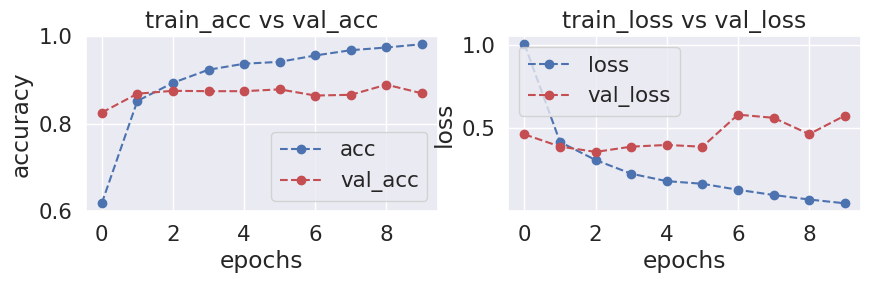

In [47]:
plot_accuracy_loss(history)

In [48]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 1s 10ms/step
Accuracy : 0.8676666666666667
